# LOAD Modules

In [4]:
%matplotlib inline
#%matplotlib widget
%load_ext autoreload
%autoreload 2


import numpy as np
from visualisations import eeg_sample_plot, events_distribution_plot
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from datasets import ChannelsVoltageDataset
from neural_nets.nn_models_getter import get_nn_model
from optimizers import get_optimizer
from utils_train import fit, test, plot_all_metrics, plot_val_metrics
from configs import configs_ozhan, configs_tim, configs_joaquin
from data_loader_creation import get_dataloader_objects
from classification_results import results_storer



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Select the configuration

In [5]:
""" USER: SELECT THE CONFIGURATION YOU NEED """
#myList = configs_tim.list_of_configs
#myList = configs_joaquin.list_of_configs
myList = configs_ozhan.list_of_configs

# Train

/home/ozhanozen/MLcourseProject/ProjectCode/data_loader_creation.py
We are not on the cluster...
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
3723 events found
Event IDs: [1 2 3]


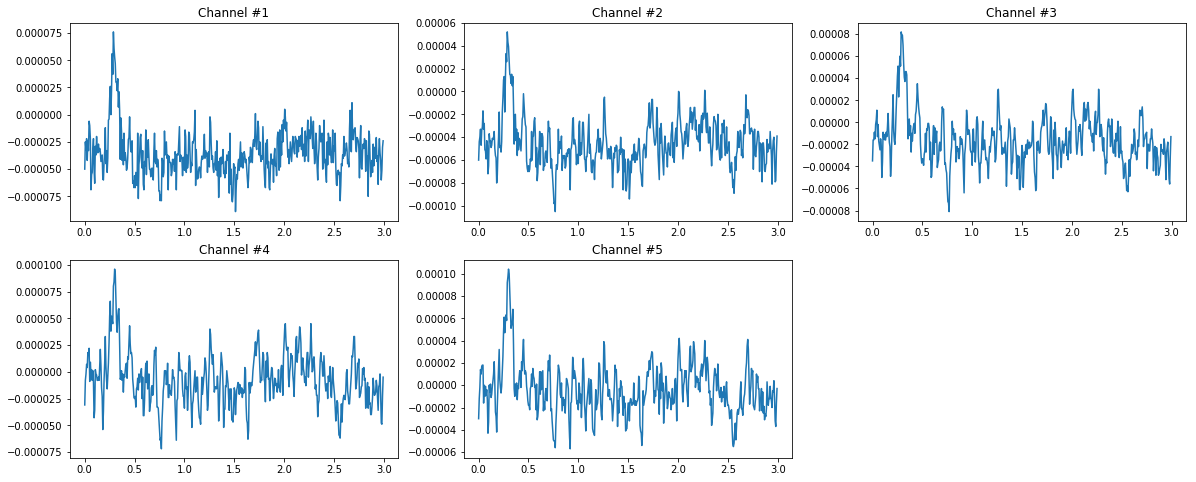

<Figure size 432x288 with 0 Axes>

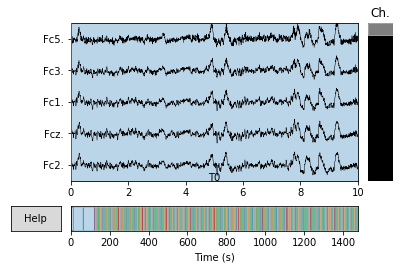

train_ds.shape (3015, 65, 817)
cuda Will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  1e-05
Epoch 1/30: train_loss: 2786826170.2386, train_accuracy: 75.9867, val_loss: 3047490837.3333, val_accuracy: 68.0597
Epoch 2/30: train_loss: 1455095274.2500, train_accuracy: 85.5721, val_loss: 115202998.6667, val_accuracy: 98.5075
Epoch 3/30: train_loss: 397146524.6667, train_accuracy: 96.1857, val_loss: 65288832.0000, val_accuracy: 98.5075
Epoch 4/30: train_loss: 1110806763.9583, train_accuracy: 90.2819, val_loss: 1995013610.6667, val_accuracy: 68.0597
Epoch 5/30: train_loss: 2044711918.5833, train_accuracy: 77.4461, val_loss: 4518657365.3333, val_accuracy: 65.6716
Epoch 6/30: train_loss: 692289317.8333, train_accuracy: 92.2056, val_loss: 66841394.0000, val_accuracy: 98.5075
Epoch 7/30: train_loss: 704897060.0833, train_accuracy: 91.1443, val_loss: 97898561.3333, val_accuracy: 98.5075
Epoch 8/30: train_loss: 221492367.9167, train_accuracy: 96.5506, val_loss: 1

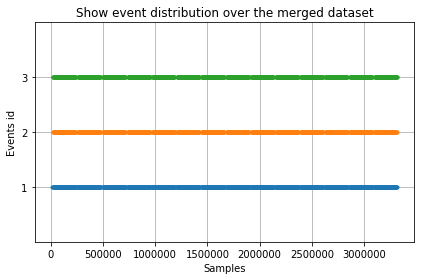

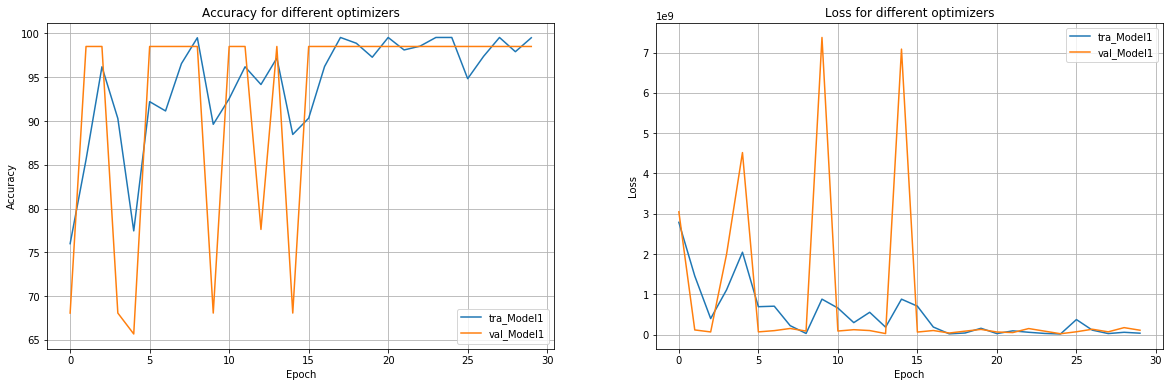

In [6]:
for my_cfg in myList:
    """ PREPARE DATALOADERS """
    train_dl, val_dl, test_dl, input_dimension_, output_dimension_ = get_dataloader_objects(my_cfg)


    """CLASSIFICATION"""
    # Get the model
    model_untrained = get_nn_model(my_cfg.nn_list[my_cfg.nn_selection_idx], input_dimension=input_dimension_,
                                   output_dimension=output_dimension_)

    # Get the optimizer
    optimizer = get_optimizer(my_cfg.optimizer_list[my_cfg.optimizer_selection_idx], my_cfg.learning_rate,
                              model_untrained.parameters(), my_cfg.momentum, my_cfg.weight_decay)

    # Train and show validation loss
    train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s =\
        fit(train_dl, val_dl, model_untrained, optimizer, my_cfg.loss_fn, my_cfg.num_of_epochs)
    
    training_curves = {}
    curves = train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s
    training_curves['Model1'] = curves
    plot_all_metrics(training_curves)
    
    # Test the net
    test_loss, test_accuracy = test(model_trained, test_dl, my_cfg.loss_fn, print_loss=True)

    # Store the results
    results_storer.store_results(my_cfg, model_trained, optimizer, test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies)



